In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.applications import MobileNet
from keras.preprocessing.image import ImageDataGenerator

# Define image dimensions
img_width, img_height = 224, 224

# Define AlexNet architecture
alexnet_model = Sequential([
    Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    Conv2D(256, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    Conv2D(384, (3, 3), activation='relu'),
    Conv2D(384, (3, 3), activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(1000, activation='softmax')  # 1000 classes in ImageNet, adjust for your task
])

# Load MobileNet pre-trained model
mobilenet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Define data generators
train_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Set your training and testing directories
train_dir = "C:\\Users\\tumma\\Desktop\\skincancerdetection\\train"
test_dir = "C:\\Users\\tumma\\Desktop\\skincancerdetection\\test"

# Define batch size
batch_size = 32

# Generate training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,  # This means our generator will only yield batches of data, no labels
    shuffle=False)  # Important to keep the same order as our labels

# Generate testing data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

# Extract features using AlexNet
alexnet_X_train_features = alexnet_model.predict(train_generator, verbose=1)
alexnet_X_test_features = alexnet_model.predict(test_generator, verbose=1)

# Extract features using MobileNet
mobilenet_X_train_features = mobilenet_model.predict(train_generator, verbose=1)
mobilenet_X_test_features = mobilenet_model.predict(test_generator, verbose=1)





Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
63/63 [==============================] - 24s 383ms/step


In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten, Concatenate
from keras.callbacks import EarlyStopping
from keras.layers import GlobalAveragePooling2D

import warnings 
warnings.filterwarnings('ignore')

# Flatten the features from AlexNet
alexnet_flat_features = Flatten()(alexnet_X_train_features)
mobilenet_pooled_features = GlobalAveragePooling2D()(mobilenet_X_train_features)

# Concatenate the flattened features with MobileNet features
concatenated_X_train_features = Concatenate()([alexnet_flat_features, mobilenet_pooled_features])

# Flatten the features from AlexNet for the test data
alexnet_flat_features_test = Flatten()(alexnet_X_test_features)
mobilenet_pooled_features_test = GlobalAveragePooling2D()(mobilenet_X_test_features)

# Concatenate the flattened features with MobileNet features for the test data
concatenated_X_test_features = Concatenate()([alexnet_flat_features_test, mobilenet_pooled_features_test])

# Get the actual class labels for training and testing data
y_train = train_generator.classes
y_test = test_generator.classes

# Define the model architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(concatenated_X_train_features.shape[1],)),  
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(concatenated_X_train_features, y_train, epochs=9, batch_size=32, validation_data=(concatenated_X_test_features, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(concatenated_X_test_features, y_test)
print('Test accuracy:', test_acc)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 128)               259200    
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_24 (Dense)            (None, 64)                8256      
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 dropout_19 (Dropout)        (None, 32)                0         
                                                                 
 dense_26 (Dense)            (None, 2)                

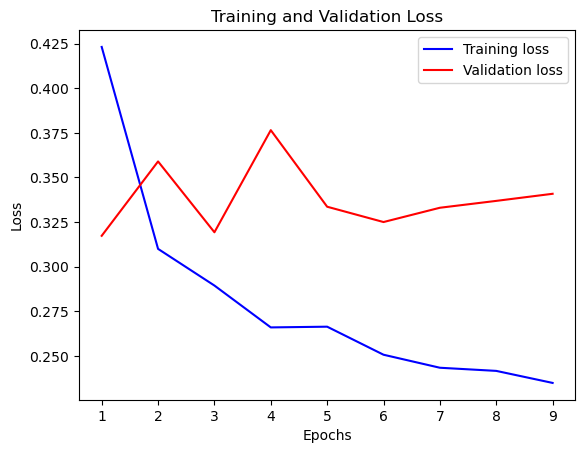

In [15]:
import matplotlib.pyplot as plt

# Extracting loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting the loss
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [13]:
from keras.preprocessing import image
import numpy as np

# Define the function to preprocess the image
def preprocess_image(img_path, input_shape):
    img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match batch size
    img_array /= 255.  # Normalize pixel values
    return img_array

def predict_image_class(img_path, alexnet_model, mobilenet_model):
    input_shape_alexnet = alexnet_model.input_shape[1:3]  # Get input shape for AlexNet model
    input_shape_mobilenet = mobilenet_model.input_shape[1:3]  # Get input shape for MobileNet model
    
    preprocessed_img_alexnet = preprocess_image(img_path, input_shape_alexnet)
    preprocessed_img_mobilenet = preprocess_image(img_path, input_shape_mobilenet)
    
    # Extract features using both AlexNet and MobileNet
    alexnet_features = alexnet_model.predict(preprocessed_img_alexnet)
    mobilenet_features = mobilenet_model.predict(preprocessed_img_mobilenet)
    
    # If the features are 4D, flatten them to 2D
    if len(alexnet_features.shape) == 4:
        alexnet_features = np.mean(alexnet_features, axis=(1, 2))  # Apply Global Average Pooling
    if len(mobilenet_features.shape) == 4:
        mobilenet_features = np.mean(mobilenet_features, axis=(1, 2))  # Apply Global Average Pooling
    
    # Concatenate the pooled feature maps
    concatenated_features = np.concatenate([alexnet_features, mobilenet_features], axis=1)
    
    # Use concatenated features to predict the class
    predictions = model.predict(concatenated_features)
    
    # Interpret predictions
    if predictions[0][0] > 0.5:
        return "Benign"
    else:
        return "Malignant"

# Test the function on an example image
test_image_path = "C:\\Users\\tumma\\Desktop\\skincancerdetection\\test\\Malignant\\5630.jpg"  # Provide the path to your test image
predicted_class = predict_image_class(test_image_path, alexnet_model, mobilenet_model)
print("Predicted class:", predicted_class)

1/1 [==============================] - 0s 37ms/step
Predicted class: Malignant
